# About (non-)linear models

Dear Vinamr, Dear Romit,

thank you for your kind responses and for sending me the data. In the following I want to illustrate an interesting aspect which I encounterd rather recently when working with POD modes.

In [10]:
# Here I just load one of your data sets
import pandas as pd
obj = pd.read_pickle(r'Data\\testing_data_N427.pickle')
data_train = obj['test_input_sequence']
data_pred  = obj['test_target_sequence']

(1487, 5)


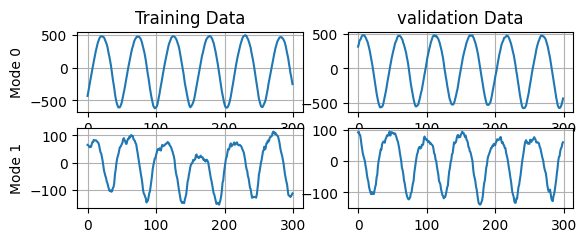

In [11]:
# Here I just plot the data for validation, seems to match the data in the paper
import matplotlib.pyplot as plt
import numpy as np
print(np.shape(data_train))
for k in range(2):
    plt.subplot(421+2*k) ; plt.plot(data_train[-300:,k]) ; plt.grid() ; plt.ylabel('Mode '+format(k))
    if(k==0):
        plt.title('Training Data')
    plt.subplot(422+2*k)
    if (k==0):
        plt.title('validation Data')
    plt.plot(data_pred[:300,k]) ; plt.grid() 

The initial aspect I encountered was that the reservoir worked better if we have a direct feed-through of the inputs, that is for instance that we append the 'reservoir state $r_t(u_t)$ with the inputs $u_t$. Thereby, we create a 'new' reservoir $\tilde{r}_t$ which can be written as
$$ \tilde{r}_t = (r_t , u_t)^T. $$
However, if you train this for comparably bad reservoirs you find that a rather valid choice for your reservoir is
$$ \tilde{r}_t = u_t. $$
which is the simplest version of a concept called 'extreme learning machine'. In other words, what one should attempt to do is to fit a linear model to the data first, that is, we want to identify A (which corresponds to the output weights in reservoir computing) such that
$$ u_{t+1} = A u_t.$$
This I will now demonstrate for your data in the following.

## Linear Model

In [13]:
Data_Matrix = np.zeros((2000,5))               # We create a data matrix
Data_Matrix[:1000,:5] = data_train[-1000:,:]   # The first half of this matrix is the training data
U_pinv = np.linalg.pinv(Data_Matrix[:999,:])   # We identify the pseudo-inverse of the training data (similar to RC)
A = np.matmul(U_pinv,data_train[-999:,:])      # We calculate A (the output weights)

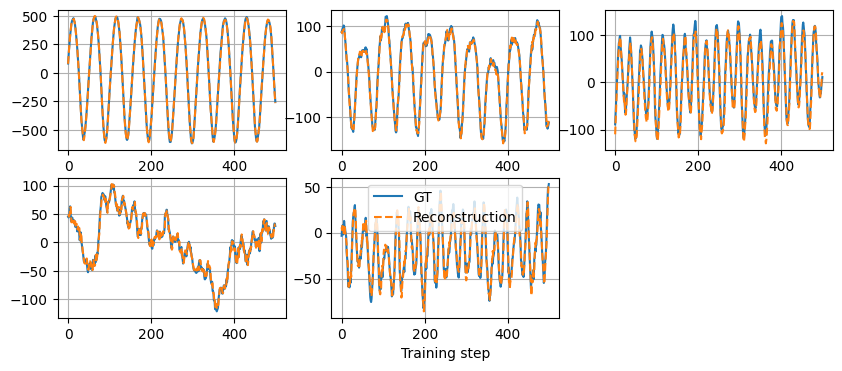

In [14]:
# Here I plot the reconstruction during training
for k in range(5):
    plt.subplot(231+k) ; plt.plot(data_train[-500:,k])          
    plt.plot(np.matmul(Data_Matrix[500-1:1000-1,:],A)[:,k],'--') ; plt.grid()
plt.xlabel('Training step')
plt.legend(['GT','Reconstruction'])  ; f = plt.gcf() ; f.set_size_inches(10,4)

In [5]:
# Here I do 'closed-loop' prediction or autonomous evolution of the linear system
Data_Matrix[999,:] = data_pred[0,:] # end of train and start of pred do not match
for t in range(1000): # Time Integration 
    Data_Matrix[1000+t,:5] = np.matmul(Data_Matrix[999+t,:],A)

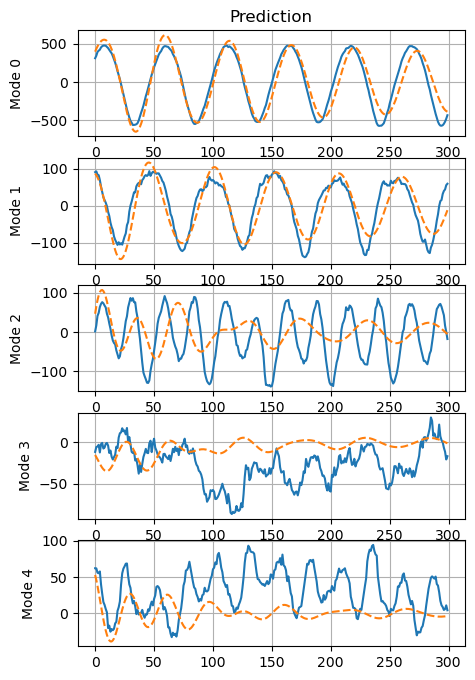

In [6]:
for k in range(5): # Here I plot the generated predictions
    plt.subplot(511+k) 
    plt.plot(data_pred[:300,k]) ; 
    if(k==0): 
        plt.title('Prediction')
    plt.plot(np.matmul(Data_Matrix[1000:1300,:],A)[:,k],'--')
    plt.grid(); plt.ylabel('Mode '+format(k))
f = plt.gcf() ; f.set_size_inches(5,8)

## Nonlinear models

I found that the approach above is either called vector autoregression (VAR) or a special instance of dynamic mode decomposition (DMD). Both have nonlinear extensions, the nonlinear VAR or extended DMD. What you basically do is that you extend your model with nonlinear features of your input data. So for instance we could choose our 'reservoir' like
$$ \tilde{r}_t = \begin{pmatrix} u_t \\ u_{2,t}\cdot u_t \\ 1 \end{pmatrix}$$
where the middle five entries are the input $u_t$ multiplied with the second mode/input $u_{2,t}$. The lower $1$ is handy to filter out biases in the data. What we now do are basically two steps:

1. Calculate $u_{t+1} = A \tilde{r}_{t}$
2. For $\tilde{r}_{t+1}$, use $u_{t+1}$ to calculate the nonlinear features

I repeat now the upper procedure with the extended model:

In [7]:
mode = 3 # counting from zero, it's actually mode 4 when counting from 1
Data_Matrix = np.zeros((2000,11))              
Data_Matrix[:1000,:5] = data_train[-1000:,:]  
for k in range(5):
    Data_Matrix[:1000,5+k] = data_train[-1000:,k] * data_train[-1000:,mode]      # added the nonlinearity
Data_Matrix[:,-1] = 1                                                            # added the constant
U_pinv = np.linalg.pinv(Data_Matrix[:999,:])   
A = np.matmul(U_pinv,data_train[-999:,:])      

Data_Matrix[999,:5]   = data_pred[0,:]
Data_Matrix[999,5:10] = data_pred[0,mode] * data_pred[0,:]                      # add nonlinearity in processing
for t in range(1000):
    Data_Matrix[1000+t,:5] = np.matmul(Data_Matrix[999+t,:],A)
    
    Data_Matrix[1000+t,5:10] = Data_Matrix[1000+t,mode] * Data_Matrix[1000+t,:5]# add nonlinearity in processing

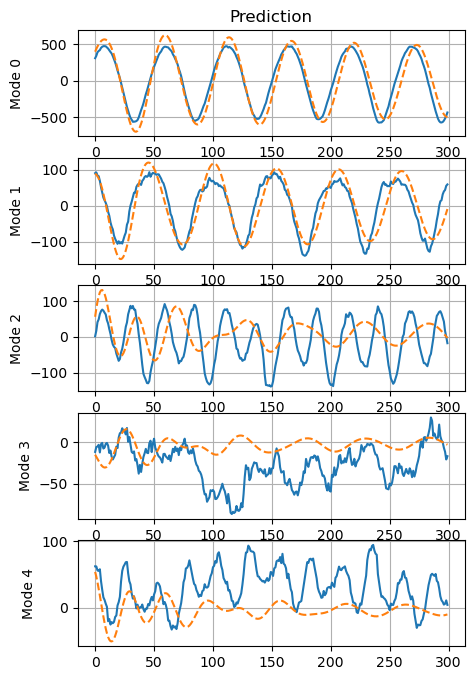

In [8]:
for k in range(5):
    plt.subplot(511+k) 
    plt.plot(data_pred[:300,k])  
    if(k==0): 
        plt.title('Prediction')
    plt.plot(np.matmul(Data_Matrix[1000:1300,:],A)[:,k],'--')
    plt.grid(); plt.ylabel('Mode '+format(k))
f = plt.gcf() ; f.set_size_inches(5,8)

Now, I would not say that we see an improvement from the linear to the nonlinear case, but it points out the way how one may extends the linear model to find better approximations. However, the problem you get rather quick is the reason why I took mode 3 above, and not for instance mode 0. It is instable:

C:\Users\phpf4185\AppData\Local\Temp\ipykernel_28440\1287732019.py:15: RuntimeWarning: overflow encountered in multiply
  Data_Matrix[1000+t,5:10] = Data_Matrix[1000+t,mode] * Data_Matrix[1000+t,:5]
C:\Users\phpf4185\AppData\Local\Temp\ipykernel_28440\1287732019.py:13: RuntimeWarning: invalid value encountered in matmul
  Data_Matrix[1000+t,:5] = np.matmul(Data_Matrix[999+t,:],A)


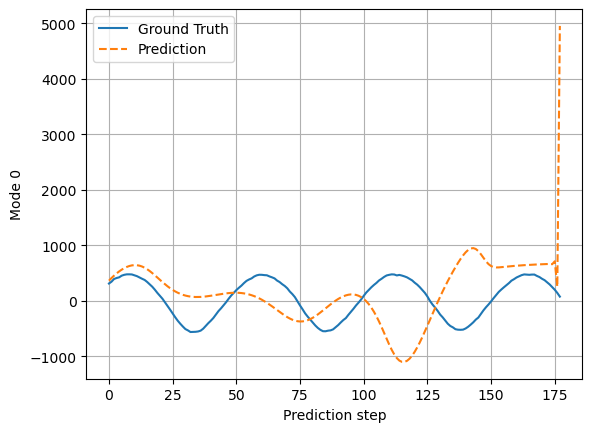

In [9]:
mode = 0 # only changed to mode 0
Data_Matrix = np.zeros((2000,11))              
Data_Matrix[:1000,:5] = data_train[-1000:,:]  
for k in range(5):
    Data_Matrix[:1000,5+k] = data_train[-1000:,k] * data_train[-1000:,mode] 
Data_Matrix[:,-1] = 1                                                         
U_pinv = np.linalg.pinv(Data_Matrix[:999,:])   
A = np.matmul(U_pinv,data_train[-999:,:])      

Data_Matrix[999,:5]   = data_pred[0,:]
Data_Matrix[999,5:10] = data_pred[0,mode] * data_pred[0,:] 
for t in range(1000):
    Data_Matrix[1000+t,:5] = np.matmul(Data_Matrix[999+t,:],A)
    
    Data_Matrix[1000+t,5:10] = Data_Matrix[1000+t,mode] * Data_Matrix[1000+t,:5]
plt.plot(data_pred[:178,0]) ; plt.xlabel('Prediction step')
plt.plot(Data_Matrix[1000:1178,0],'--') ; plt.legend(['Ground Truth', 'Prediction']) ; plt.ylabel('Mode 0') ; plt.grid()

## The problem
How does one proceed from the linear model in the case of POD modes? As it turns out, product concatenations (which are the go-to I encountered in my literature research) tend to be tremendously instable quite fast. Even if they are stable, they often tend to give no significant benefit to the prediction quality.

## Proposal

If you are interested, we could extend your work or start a new one resolving around the following aspects:

- Does the combination of a (non-)linear model and reservoir computing (my original formula for $\tilde{r}_t = (r_t , u_t)^T$ outperform the results of the reservoir or the linear model?
- Can we find product nonlinearities which indeed improve the quality for this dataset?
- Can we find other beneficial nonlinear transformations?